In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based
#sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [8]:
from __future__ import division, print_function
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

In [10]:
problem = {
  'num_vars': 6,
  'names': ['random-seed',
            'grass-regrowth-time',
            'sheep-gain-from-food',
            'wolf-gain-from-food',
            'sheep-reproduce',
            'wolf-reproduce'],
  'bounds': [[1, 100000],
             [20., 40.],
             [2., 8.],
             [16., 32.],
             [2., 8.],
             [2., 8.]]
}

In [12]:
n = 10
param_values = saltelli.sample(problem, n, calc_second_order=True)

In [19]:
import ipyparallel

client = ipyparallel.Client()
client.ids

[0, 1, 2, 3]

In [20]:
direct_view = client[:]

In [21]:
import os

#Push the current working directory of the notebook to a "cwd" variable on the engines that can be accessed later
direct_view.push(dict(cwd=os.getcwd()))

<AsyncResult: _push>

In [22]:

#Push the "problem" variable from the notebook to a corresponding variable on the engines
direct_view.push(dict(problem=problem))

<AsyncResult: _push>

In [29]:
%%px

import os
os.chdir(cwd)

import pyNetLogo
import pandas as pd

netlogo = pyNetLogo.NetLogoLink(gui=False)
netlogo.load_model('./model/Wolf Sheep Predation_v6.nlogo')

In [30]:
def simulation(experiment):

    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(experiment[i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, experiment[i]))

    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['count sheep','count wolves'], 100)

    results = pd.Series([counts['count sheep'].values.mean(),
                         counts['count wolves'].values.mean()],
                         index=['Avg. sheep', 'Avg. wolves'])

    return results

In [31]:
lview = client.load_balanced_view()

results = pd.DataFrame(lview.map_sync(simulation, param_values))

In [32]:
results.head(5)

,Avg. sheep,Avg. wolves
0,125.25,91.52
1,136.85,110.37
2,125.98,84.50
3,136.46,106.76
4,284.34,55.39


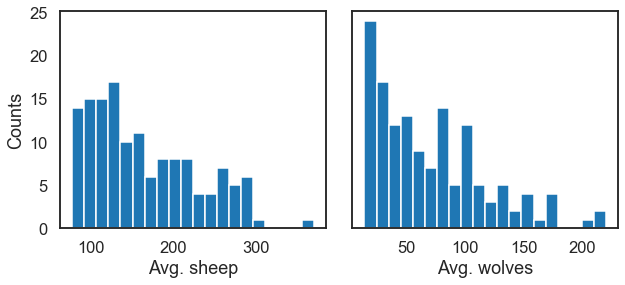

In [33]:

fig, ax = plt.subplots(1,len(results.columns), sharey=True)

for i, n in enumerate(results.columns):
    ax[i].hist(results[n], 20)
    ax[i].set_xlabel(n)
ax[0].set_ylabel('Counts')

fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=0.1)

plt.show()

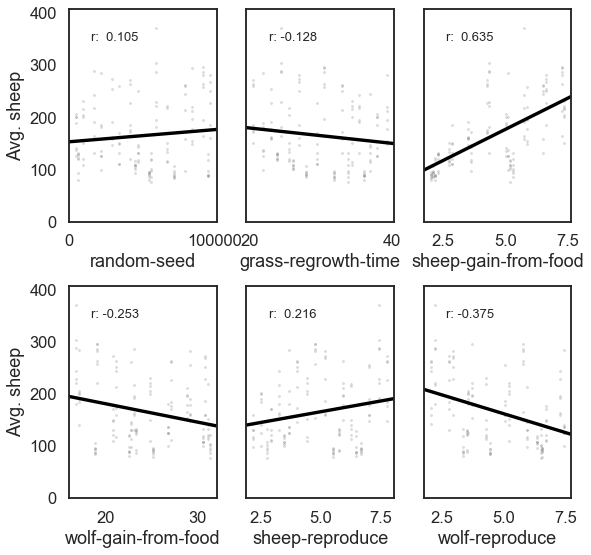

In [34]:

import scipy

nrow=2
ncol=3

fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = results['Avg. sheep']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(9,9,forward=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

In [35]:
Si = sobol.analyze(problem, results['Avg. sheep'].values, calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

In [36]:
Si_df

,ST,ST_conf,S1,S1_conf
random-seed,0.016048,0.010909,0.006289,0.121736
grass-regrowth-time,0.122280,0.099785,0.178067,0.202510
sheep-gain-from-food,0.292986,0.277948,0.321480,0.286438
wolf-gain-from-food,0.316832,0.478846,0.210208,0.304282
sheep-reproduce,0.201969,0.247529,0.035707,0.246535
wolf-reproduce,0.185252,0.148490,0.033927,0.223425


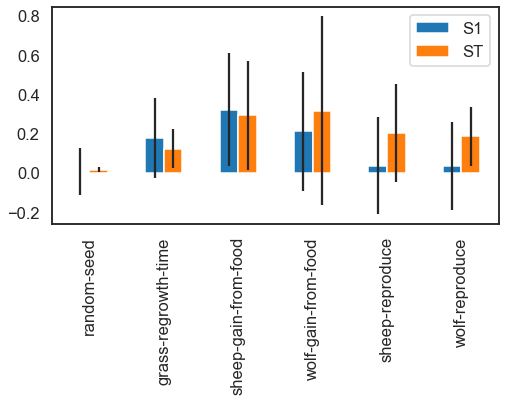

In [37]:
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()